### Proses

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

**Set Seed** : Digunakan ntuk mengontrol hasil dari operasi acak yang dilakukan oleh TensorFlow. Dengan menetapkan seed yang sama, setiap kali kita menjalankan kode yang menggunakan fungsi acak, hasilnya akan sama jika kondisinya juga sama. Menetapkan biji acak akan membantu menjaga konsistensi hasil antara percobaan yang berbeda.

Mengatur biji acak memungkinkan Anda mendapatkan hasil yang sama setiap kali Anda menjalankan model atau eksperimen. Ini sangat penting untuk mereproduksi hasil yang konsisten, mempermudah debugging, dan memungkinkan komparabilitas di antara berbagai percobaan atau pengaturan model.

In [ ]:
import pandas as pd
df = pd.read_csv("drive/MyDrive/BRIN_Dataset/daily_news_interpolasi_modus.csv")
df

,date_published,event_daily_news
0,1/7/2020,0
1,1/8/2020,0
2,1/9/2020,0
3,1/10/2020,0
4,1/11/2020,0
...,...,...
132,5/18/2020,157
133,5/19/2020,203
134,5/20/2020,161
135,5/21/2020,163


In [ ]:
# fix random seed for reproducibility
tf.random.set_seed(7)

**Konversi df_result** : dari format tanggal (datetime) menjadi nilai numerik dengan menghitung nilai epoch. DataFrame df_result kemudian diubah menjadi array NumPy menggunakan .values. Setelah itu, tipe data array diubah menjadi float32

In [ ]:
df['date_published'] = df['date_published'].astype('datetime64[ns]').astype(int) / 10**9

# load the dataset
dataset = pd.read_csv('drive/MyDrive/BRIN_Dataset/daily_news_interpolasi_modus.csv', usecols=[1], engine='python', error_bad_lines=False)
dataset = dataset.values
dataset = dataset.astype('float32')

<ipython-input-5-e52f557efd7f>:4: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  dataset = pd.read_csv('drive/MyDrive/BRIN_Dataset/daily_news_interpolasi_modus.csv', usecols=[1], engine='python', error_bad_lines=False)


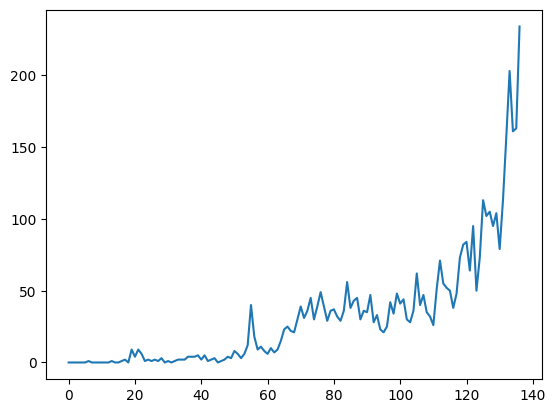

In [ ]:
plt.plot(dataset)
plt.show()

**Normalisasi** : proses di mana nilai-nilai dari variabel-variabel dalam dataset diubah sedemikian rupa sehingga variabel-variabel tersebut memiliki skala atau rentang nilai tertentu.

In [ ]:
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

**Split** : pembagian dataset menjadi set pelatihan (train set) dan set pengujian (test set)

In [ ]:
# split into train and test sets
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
print(len(train), len(test))

91 46


In [ ]:
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

# split into train and test sets
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]


Mengkonversi sebuah array nilai menjadi matriks dataset

In [ ]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
    # Inisialisasi dua list untuk menyimpan input (data latih) dan output (target)
    dataX, dataY = [], []

    # Iterasi melalui dataset dengan jendela sepanjang look_back
    for i in range(len(dataset)-look_back-1):
        # Buat jendela (input) sepanjang look_back
        a = dataset[i:(i+look_back), 0]

        # Tambahkan jendela ke dalam data latih (input)
        dataX.append(a)

        # Tambahkan nilai target (output) yang sesuai untuk jendela ke dalam data target
        dataY.append(dataset[i + look_back, 0])

    # Mengembalikan data latih dan data target dalam bentuk array NumPy
    return np.array(dataX), np.array(dataY)

 Menguji model pada data

In [ ]:
# Set look_back untuk menentukan ukuran jendela (window size)
look_back = 1

# Membuat dataset latih menggunakan fungsi create_dataset
# Dataset ini digunakan untuk memprediksi Y=t+1 berdasarkan X=t
trainX, trainY = create_dataset(train, look_back)

# Membuat dataset uji menggunakan fungsi create_dataset
# Dataset ini digunakan untuk menguji performa model pada data yang belum dilihat sebelumnya
testX, testY = create_dataset(test, look_back)

Mengubah bentuk dataset train dan test ke dalam format tiga dimensi

In [ ]:
# Reshape input menjadi [samples, time steps, features]
# Ini diperlukan karena beberapa model memerlukan input dalam bentuk tiga dimensi [samples, time steps, features]

# Reshape dataset latih
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))

# Reshape dataset uji
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

### Model

In [ ]:
from keras.models import Sequential
from keras.layers import Dense

model = Sequential()

# Ganti LSTM layer dengan Dense layer
model.add(Dense(4, input_shape=(look_back,)))

# Hapus input_shape pada Dense layer jika tidak diperlukan
# model.add(Dense(4))

# Ganti layer output sesuai dengan kebutuhan
model.add(Dense(1))
model.summary()



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 4)                 8         
                                                                 
 dense_1 (Dense)             (None, 1)                 5         
                                                                 
Total params: 13 (52.00 Byte)
Trainable params: 13 (52.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:

model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=2)

Epoch 1/100
89/89 - 2s - loss: 0.0149 - 2s/epoch - 19ms/step
Epoch 2/100
89/89 - 0s - loss: 0.0112 - 200ms/epoch - 2ms/step
Epoch 3/100
89/89 - 0s - loss: 0.0088 - 234ms/epoch - 3ms/step
Epoch 4/100
89/89 - 0s - loss: 0.0068 - 318ms/epoch - 4ms/step
Epoch 5/100
89/89 - 0s - loss: 0.0051 - 218ms/epoch - 2ms/step
Epoch 6/100
89/89 - 0s - loss: 0.0040 - 167ms/epoch - 2ms/step
Epoch 7/100
89/89 - 0s - loss: 0.0032 - 239ms/epoch - 3ms/step
Epoch 8/100
89/89 - 0s - loss: 0.0024 - 204ms/epoch - 2ms/step
Epoch 9/100
89/89 - 0s - loss: 0.0018 - 189ms/epoch - 2ms/step
Epoch 10/100
89/89 - 0s - loss: 0.0014 - 107ms/epoch - 1ms/step
Epoch 11/100
89/89 - 0s - loss: 0.0012 - 108ms/epoch - 1ms/step
Epoch 12/100
89/89 - 0s - loss: 0.0010 - 110ms/epoch - 1ms/step
Epoch 13/100
89/89 - 0s - loss: 9.4657e-04 - 106ms/epoch - 1ms/step
Epoch 14/100
89/89 - 0s - loss: 8.8288e-04 - 112ms/epoch - 1ms/step
Epoch 15/100
89/89 - 0s - loss: 8.1007e-04 - 104ms/epoch - 1ms/step
Epoch 16/100
89/89 - 0s - loss: 9.2207e

In [ ]:
# Membuat prediksi menggunakan model yang telah dilatih

# Melakukan prediksi pada dataset latih
trainPredict = model.predict(trainX)

# Melakukan prediksi pada dataset uji
testPredict = model.predict(testX)

# Mengembalikan prediksi ke dalam skala aslinya
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

# Menghitung nilai Root Mean Squared Error (RMSE) untuk evaluasi performa model

# Menghitung RMSE untuk dataset latih
trainScore = np.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))

# Menghitung RMSE untuk dataset uji
testScore = np.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

2/2 [==============================] - 0s 5ms/step
Train Score: 0.03 RMSE
Test Score: 0.09 RMSE


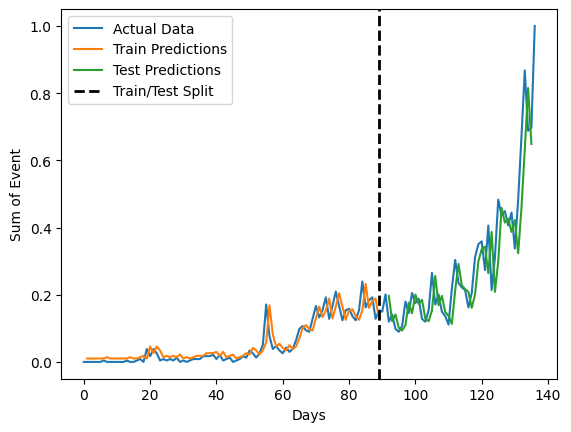

In [ ]:
# Membuat array kosong dengan bentuk yang sama seperti dataset
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan

# Menempatkan prediksi latih ke dalam array yang telah dibuat
# Dimulai dari indeks look_back hingga len(trainPredict)+look_back
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict

# Membuat array kosong dengan bentuk yang sama seperti dataset
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan

# Menempatkan prediksi uji ke dalam array yang telah dibuat
# Dimulai dari indeks len(trainPredict)+(look_back*2)+1 hingga len(dataset)-1
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict


# Plot baseline (data asli) dan hasil prediksi (latih dan uji)
plt.plot(scaler.inverse_transform(dataset), label='Actual Data')
plt.plot(trainPredictPlot, label='Train Predictions')
plt.plot(testPredictPlot, label='Test Predictions')
plt.xlabel('Days')
plt.ylabel('Sum of Event')
plt.axvline(x=len(trainPredict), color='black', linestyle='--', linewidth=2, label='Train/Test Split')
plt.legend()  # Menambahkan legenda untuk membedakan antara data asli, prediksi latih, dan prediksi uji
plt.show()


In [ ]:
import pandas as pd

# Membuat array kosong dengan bentuk yang sama seperti dataset
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan

# Menempatkan prediksi latih ke dalam array yang telah dibuat
# Dimulai dari indeks look_back hingga len(trainPredict)+look_back
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict

# Membuat array kosong dengan bentuk yang sama seperti dataset
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan

# Menempatkan prediksi uji ke dalam array yang telah dibuat
# Dimulai dari indeks len(trainPredict)+(look_back*2)+1 hingga len(dataset)-1
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict

# Mengembalikan data asli ke dalam skala aslinya untuk membangun tabel
actual_data = scaler.inverse_transform(dataset)
train_predictions = scaler.inverse_transform(trainPredictPlot)
test_predictions = scaler.inverse_transform(testPredictPlot)

# Menyiapkan DataFrame untuk data asli, prediksi latih, dan prediksi uji
result_df = pd.DataFrame({
    'Actual Data': actual_data.flatten(),
    'Train Predictions': train_predictions.flatten(),
    'Test Predictions': test_predictions.flatten()
})

# Menampilkan tabel hasil prediksi
result_df


,Actual Data,Train Predictions,Test Predictions
0,0.000000,NaN,NaN
1,0.000000,0.010199,NaN
2,0.000000,0.010199,NaN
3,0.000000,0.010199,NaN
4,0.000000,0.010199,NaN
...,...,...,...
132,0.670940,NaN,0.458275
133,0.867521,NaN,0.632748
134,0.688034,NaN,0.815151
135,0.696581,NaN,0.648609


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import numpy as np

# Ambang batas untuk mengubah prediksi menjadi kelas biner
threshold = 0.5  # Sesuaikan dengan kebutuhan Anda

# Mengubah target menjadi biner
trainYBinary = np.where(trainY[0] > threshold, 1, 0)
testYBinary = np.where(testY[0] > threshold, 1, 0)

# Mengubah prediksi menjadi kelas biner
trainPredictBinary = np.where(trainPredict > threshold, 1, 0)
testPredictBinary = np.where(testPredict > threshold, 1, 0)

# Menghitung metrik-metrik evaluasi
trainAccuracy = accuracy_score(trainYBinary, trainPredictBinary)
testAccuracy = accuracy_score(testYBinary, testPredictBinary)

trainPrecision = precision_score(trainYBinary, trainPredictBinary)
testPrecision = precision_score(testYBinary, testPredictBinary)

trainRecall = recall_score(trainYBinary, trainPredictBinary)
testRecall = recall_score(testYBinary, testPredictBinary)

trainF1 = f1_score(trainYBinary, trainPredictBinary)
testF1 = f1_score(testYBinary, testPredictBinary)

# Menampilkan hasil
print('Train Accuracy:', trainAccuracy)
print('Test Accuracy:', testAccuracy)

print('Train Precision:', trainPrecision)
print('Test Precision:', testPrecision)

print('Train Recall:', trainRecall)
print('Test Recall:', testRecall)

print('Train F1 Score:', trainF1)
print('Test F1 Score:', testF1)


Train Accuracy: 1.0
Test Accuracy: 0.9772727272727273
Train Precision: 0.0
Test Precision: 1.0
Train Recall: 0.0
Test Recall: 0.75
Train F1 Score: 0.0
Test F1 Score: 0.8571428571428571


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
